# Continuous Photobleaching (CP)

$I(t) = I_0 e^{(-Bt)} + I_{Bg}$

$I(x) = I_0 e^{-x \sqrt{B/D}} + I_{Bg}$

where $I_0 , I_{Bg}, B, D$ are fitting parameters.

$I_0$: Initial intensity

$I_{Bg}$: Background intensity

$B$: Bleaching rate of the fluorophores

$D$: Diffusion constant

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import center_of_mass
from skimage import io, filters

### Read the movie stack and display average and histogram.

Data shape = (580, 712, 694)
The baseline removed = 269.0


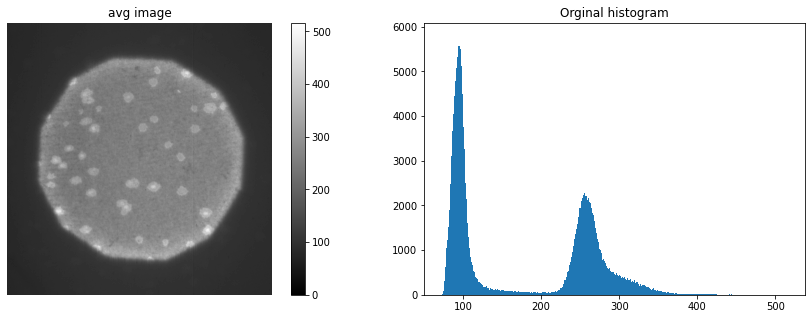

In [2]:
# Read the movie stack
stack = io.imread("data/20210928_BioAvidin_negative/movie-600-fast2.tif")[20:, 180:-110, 160:-150].astype(np.float64)

# Print the dimension of the stack
print(f'Data shape = {stack.shape}')

# Remove the baseline
print(f'The baseline removed = {stack.min()}')
stack -= stack.min()

# display the average and it's histogram
plt.figure(figsize=(15,5))

# Average the movie
avg = np.mean(stack, axis=0)

plt.subplot(121)
plt.axis('off')
plt.title('avg image')
plt.imshow(avg, cmap = "gray", vmin=0)
plt.colorbar();

plt.subplot(122)
plt.title('Orginal histogram')
plt.hist(avg.ravel(), bins = 1000);
#plt.xlim(300,800);

### Display the Begining and the End of the stack with better contrast

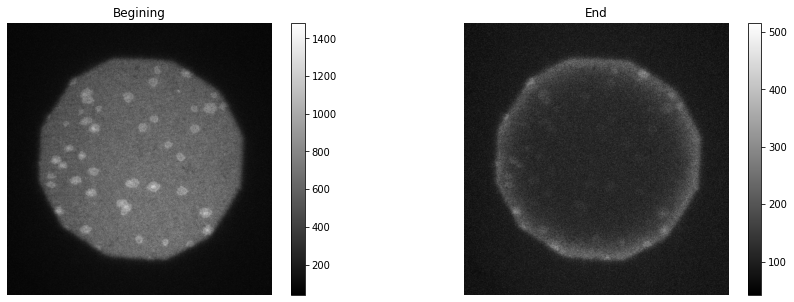

In [3]:
# display the image with better brightness and contrast
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Begining')
plt.imshow(stack[:5].mean(axis = 0), cmap = "gray")
plt.colorbar();

plt.subplot(122)
plt.axis('off')
plt.title('End')
plt.imshow(stack[-5:].mean(axis = 0), cmap = "gray")
plt.colorbar();

### Measure the radius and the center on the diaphragm

In [4]:
# Getting the threshold of edge filtered image
threshold = filters.threshold_otsu(avg)

# Making a binary mask image with 0 and 1 values
mask = np.multiply(avg > threshold, 1)

# Measure the radius of the diaphragm by treating it as a circle with area = Pi*R^2
radius = int(np.sqrt(np.sum(mask)/(np.pi)))

# Measure the center of mass for the mask and transform it into integer array.
center = np.array(center_of_mass(mask)).astype(int)

print(f'Radius = {radius}\nCenter = {center}')

Radius = 269
Center = [355 350]


### Display the radius and the center and the regoins of interest

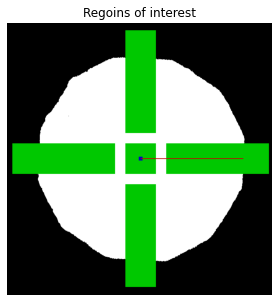

In [5]:
# Get an RGB copy of the mask
umask = np.zeros([mask.shape[0], mask.shape[1],3]).astype('uint8')
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        umask[i,j] = mask[i,j] * np.array([255, 255, 255])

# Draw the regions to be measured
umask[center[0]-40:center[0]+40, center[1]-40:center[1]+40] = [0,200,0]                         # Rectangle center
umask[center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)] = [0,200,0] # Rectangle right
umask[center[0]-40:center[0]+40, center[1]-int(radius*5/4):center[1]-int(radius/4)] = [0,200,0] # Rectangle left
umask[center[0]-int(radius*5/4):center[0]-int(radius/4), center[1]-40:center[1]+40] = [0,200,0] # Rectangle up
umask[center[0]+int(radius/4):center[0]+int(radius*5/4), center[1]-40:center[1]+40] = [0,200,0] # Rectangle down


# Draw the radius and the center on the mask
umask[center[0]-5:center[0]+5, center[1]-5:center[1]+5] = [0,0,200] # Center
umask[center[0]-1:center[0]+1, center[1]:center[1]+radius] = [200,0,0] # Radius

# display the image with better brightness and contrast
plt.figure(figsize=(7,5))
plt.axis('off')
plt.title('Regoins of interest')
plt.imshow(umask);

In [6]:
# plt.axis('off')
# plt.imshow(stack[-5:,center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)], cmap = "gray")
# plt.colorbar();

(580,) (269,)


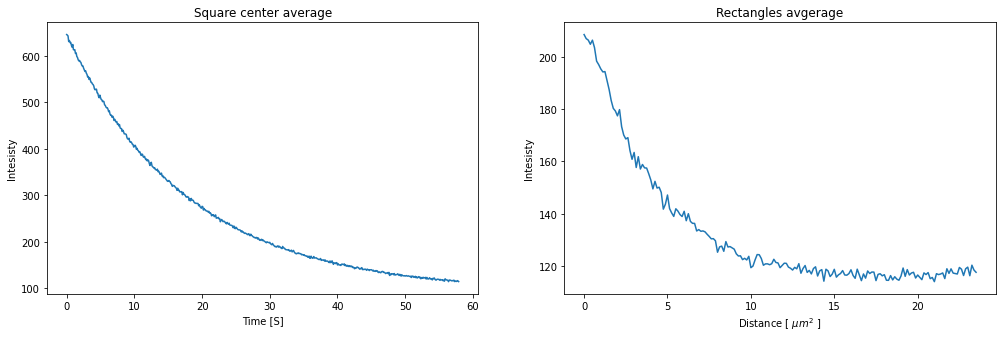

In [25]:
# Take the means to get the curves
square_center    = np.mean(stack[:,center[0]-40:center[0]+40, center[1]-40:center[1]+40],
                           axis=(1,2))
rectangle_right  = np.mean(stack[-5:,center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)],
                           axis=(0,1))
rectangle_left   = np.mean(stack[-5:,center[0]-40:center[0]+40, center[1]-int(radius*5/4):center[1]-int(radius/4)],
                           axis=(0,1))
rectangle_up     = np.mean(stack[-5:,center[0]-int(radius*5/4):center[0]-int(radius/4), center[1]-40:center[1]+40],
                           axis=(0,2))
rectangle_down   = np.mean(stack[-5:,center[0]+int(radius/4):center[0]+int(radius*5/4), center[1]-40:center[1]+40],
                           axis=(0,2))

# Reverse the right and the down rectangle
rectangle_right = rectangle_right[::-1]
rectangle_down  = rectangle_down[::-1]

# Take the average of the rectangles
rectangle_avg = np.mean([rectangle_right, rectangle_left, rectangle_up, rectangle_down], axis=0)

print(square_center.shape, rectangle_avg.shape)

# display the image with better brightness and contrast
plt.figure(figsize=(17,5))

plt.subplot(121)
plt.plot(np.arange(square_center.shape[0]) * 0.1, square_center)
plt.title('Square center average')
plt.xlabel('Time [S]')
plt.ylabel('Intesisty')

plt.subplot(122)
plt.plot(np.arange(rectangle_avg[80:].shape[0]) * 0.125, rectangle_avg[80:])
plt.title('Rectangles avgerage');
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty');

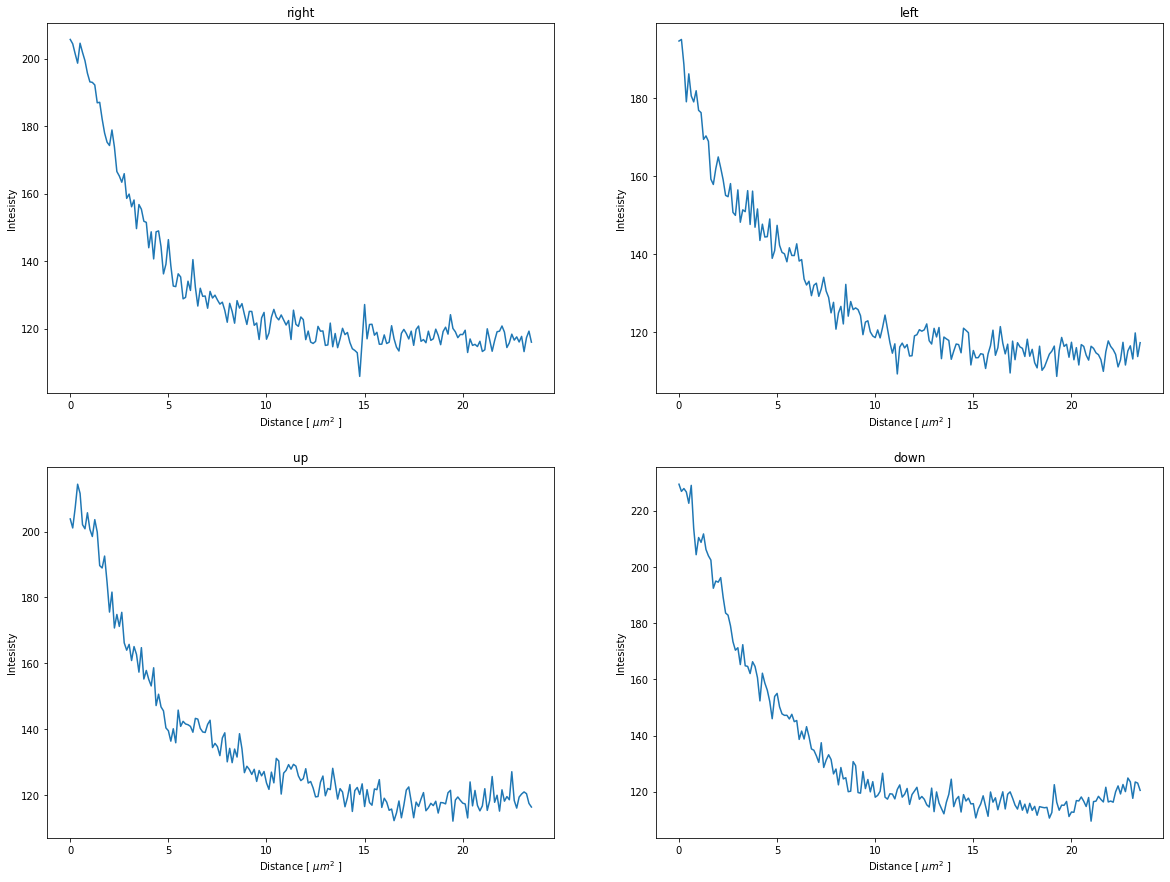

In [17]:
# display the 4 rectangle profiles
plt.figure(figsize=(20,15))

plt.subplot(221)
plt.plot(np.arange(rectangle_right[80:].shape[0]) * 0.125, rectangle_right[80:])
plt.title('right')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')

plt.subplot(222)
plt.plot(np.arange(rectangle_left[80:].shape[0]) * 0.125, rectangle_left[80:])
plt.title('left')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')

plt.subplot(223)
plt.plot(np.arange(rectangle_up[80:].shape[0]) * 0.125, rectangle_up[80:])
plt.title('up')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')

plt.subplot(224)
plt.plot(np.arange(rectangle_down[80:].shape[0]) * 0.125, rectangle_down[80:])
plt.title('down')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty');